<a href="https://colab.research.google.com/github/pach28/Forecasting-Sticker-Sales/blob/main/forecasting_sticker_sales_Eda_%26_classification_plus_ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
kagglehub.login()

In [ ]:
playground_series_s5e1_path = kagglehub.competition_download('playground-series-s5e1')

print('Data source import complete.')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os

# Download the competition dataset
playground_series_s5e1_path = kagglehub.competition_download('playground-series-s5e1')

# Extract the directory name from the downloaded path
dataset_dir = os.path.splitext(playground_series_s5e1_path)[0]

# Construct the correct paths to the train.csv and test.csv files
train_csv_path = os.path.join(dataset_dir, 'train.csv')
test_csv_path = os.path.join(dataset_dir, 'test.csv')

# Read the CSV files using the correct paths
train = pd.read_csv(train_csv_path, parse_dates=["date"])
test = pd.read_csv(test_csv_path, parse_dates=["date"])

In [ ]:
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [ ]:
test.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [ ]:
#conteo de NaN por tienda
train.groupby('store')['num_sold'].apply(lambda x: x.isna().sum())

,num_sold
store,
Discount Stickers,5179
Premium Sticker Mart,1026
Stickers for Less,2666


In [ ]:
#conteo de tipo de product de train
train['product'].value_counts()

,count
product,
Holographic Goose,46026
Kaggle,46026
Kaggle Tiers,46026
Kerneler,46026
Kerneler Dark Mode,46026


In [ ]:
#media num_sold por product
train.groupby('product')['num_sold'].mean()

,num_sold
product,
Holographic Goose,197.484363
Kaggle,1232.384587
Kaggle Tiers,1018.344110
Kerneler,556.913102
Kerneler Dark Mode,651.042021


In [ ]:
#media de num_sold por store
train.groupby('store')['num_sold'].mean()

,num_sold
store,
Discount Stickers,427.775887
Premium Sticker Mart,973.836240
Stickers for Less,840.046418


In [ ]:
#media de num_sold por pais
train.groupby('country')['num_sold'].mean()

,num_sold
country,
Canada,840.045003
Finland,748.243306
Italy,542.241403
Kenya,20.431100
Norway,1422.560422
Singapore,863.052379


#para las fechas como se menciona en los objetivos se identificaran los fines de semana, se podran agrupar ventas por meses o por trimestres, asi como dias festivos de cada pais si es posible

#para paises se codificara en variables categoricas por one-hot encoding

In [ ]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

creamos columnas para las vacaciones de cada pais

In [ ]:
import holidays
# Crear un objeto de holidays para Canadá
ca_holidays = holidays.CA()
fi_holidays = holidays.FI()
it_holidays = holidays.IT()
ke_holidays = holidays.KE()
no_holidays = holidays.NO()
sg_holidays = holidays.SG()

# Crear una nueva columna para indicar si es festivo en train
train['is_ca_holiday'] = train.apply(lambda row: 1 if row['date'] in ca_holidays and row['country'] == 'Canada' else 0, axis=1)
train['is_fi_holiday'] = train.apply(lambda row: 1 if row['date'] in fi_holidays and row['country'] == 'Finland' else 0, axis=1)
train['is_it_holiday'] = train.apply(lambda row: 1 if row['date'] in it_holidays and row['country'] == 'Italy' else 0, axis=1)
train['is_ke_holiday'] = train.apply(lambda row: 1 if row['date'] in ke_holidays and row['country'] == 'Kenya' else 0, axis=1)
train['is_no_holiday'] = train.apply(lambda row: 1 if row['date'] in no_holidays and row['country'] == 'Norway' else 0, axis=1)
train['is_sg_holiday'] = train.apply(lambda row: 1 if row['date'] in sg_holidays and row['country'] == 'Singapore' else 0, axis=1)
# Crear una nueva columna para indicar si es festivo en test
test['is_ca_holiday'] = test.apply(lambda row: 1 if row['date'] in ca_holidays and row['country'] == 'Canada' else 0, axis=1)
test['is_fi_holiday'] = test.apply(lambda row: 1 if row['date'] in fi_holidays and row['country'] == 'Finland' else 0, axis=1)
test['is_it_holiday'] = test.apply(lambda row: 1 if row['date'] in it_holidays and row['country'] == 'Italy' else 0, axis=1)
test['is_ke_holiday'] = test.apply(lambda row: 1 if row['date'] in ke_holidays and row['country'] == 'Kenya' else 0, axis=1)
test['is_no_holiday'] = test.apply(lambda row: 1 if row['date'] in no_holidays and row['country'] == 'Norway' else 0, axis=1)
test['is_sg_holiday'] = test.apply(lambda row: 1 if row['date'] in sg_holidays and row['country'] == 'Singapore' else 0, axis=1)

In [ ]:
def prepare_features(df):
    df['dia_semana'] = df['date'].dt.dayofweek
    df['mes'] = df['date'].dt.month
    df['es_finde'] = df['date'].dt.dayofweek >= 5
    df['es_finde'] = df['es_finde'].astype(int)
    df['trimestre'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df.drop('date', axis=1, inplace=True)
    return df


In [ ]:
train_prepared = prepare_features(train)
train_prepared.head()

,id,country,store,product,num_sold,is_ca_holiday,is_fi_holiday,is_it_holiday,is_ke_holiday,is_no_holiday,is_sg_holiday,dia_semana,mes,es_finde,trimestre,year
0,0,Canada,Discount Stickers,Holographic Goose,NaN,1,0,0,0,0,0,4,1,0,1,2010
1,1,Canada,Discount Stickers,Kaggle,973.0,1,0,0,0,0,0,4,1,0,1,2010
2,2,Canada,Discount Stickers,Kaggle Tiers,906.0,1,0,0,0,0,0,4,1,0,1,2010
3,3,Canada,Discount Stickers,Kerneler,423.0,1,0,0,0,0,0,4,1,0,1,2010
4,4,Canada,Discount Stickers,Kerneler Dark Mode,491.0,1,0,0,0,0,0,4,1,0,1,2010


In [ ]:
test_prepared = prepare_features(test)
test_prepared.head()

,id,country,store,product,is_ca_holiday,is_fi_holiday,is_it_holiday,is_ke_holiday,is_no_holiday,is_sg_holiday,dia_semana,mes,es_finde,trimestre,year
0,230130,Canada,Discount Stickers,Holographic Goose,1,0,0,0,0,0,6,1,1,1,2017
1,230131,Canada,Discount Stickers,Kaggle,1,0,0,0,0,0,6,1,1,1,2017
2,230132,Canada,Discount Stickers,Kaggle Tiers,1,0,0,0,0,0,6,1,1,1,2017
3,230133,Canada,Discount Stickers,Kerneler,1,0,0,0,0,0,6,1,1,1,2017
4,230134,Canada,Discount Stickers,Kerneler Dark Mode,1,0,0,0,0,0,6,1,1,1,2017


In [ ]:
#ver el promedio de ventas por fin de semana de cada tienda
train.groupby(['store', 'dia_semana'])['num_sold'].mean()

store                 dia_semana
Discount Stickers     0              403.526986
                      1              404.162255
                      2              404.049299
                      3              403.888813
                      4              427.886264
                      5              451.241511
                      6              499.471722
Premium Sticker Mart  0              922.915604
                      1              922.286724
                      2              922.506788
                      3              923.754283
                      4              972.332381
                      5             1022.347021
                      6             1127.531496
Stickers for Less     0              798.181653
                      1              797.380435
                      2              799.327733
                      3              798.127885
                      4              839.876320
                      5              880.442263
                      6              962.264700
Name: num_sold, dtype: float64

In [ ]:
#promedio de ventas por tienda y producto
train.groupby(['store', 'product'])['num_sold'].mean()

store                 product           
Discount Stickers     Holographic Goose      117.176379
                      Kaggle                 683.274932
                      Kaggle Tiers           564.448507
                      Kerneler               309.357900
                      Kerneler Dark Mode     360.590183
Premium Sticker Mart  Holographic Goose      239.381671
                      Kaggle                1632.278060
                      Kaggle Tiers          1349.254791
                      Kerneler               736.491135
                      Kerneler Dark Mode     862.658715
Stickers for Less     Holographic Goose      214.965289
                      Kaggle                1381.600769
                      Kaggle Tiers          1141.329031
                      Kerneler               623.857580
                      Kerneler Dark Mode     729.858232
Name: num_sold, dtype: float64

In [ ]:
train.groupby(['country','store'])['num_sold'].mean()

country    store               
Canada     Discount Stickers        502.421433
           Premium Sticker Mart    1034.500282
           Stickers for Less        930.718393
Finland    Discount Stickers        414.561830
           Premium Sticker Mart     991.446304
           Stickers for Less        838.721783
Italy      Discount Stickers        300.294955
           Premium Sticker Mart     718.715839
           Stickers for Less        607.713414
Kenya      Discount Stickers         11.945691
           Premium Sticker Mart      25.503995
           Stickers for Less         22.589656
Norway     Discount Stickers        788.472429
           Premium Sticker Mart    1883.838092
           Stickers for Less       1595.370747
Singapore  Discount Stickers        478.646304
           Premium Sticker Mart    1142.898709
           Stickers for Less        967.612124
Name: num_sold, dtype: float64

vemos un comportamiento en los productos dependiendo el pais , por lo tanto un onehotencoder seria ideal

In [ ]:
from sklearn.preprocessing import OneHotEncoder

#one-hot encoding for categorical features
encoder = OneHotEncoder()
categorical_features = ['country', 'store', 'product']
encoded_features = encoder.fit_transform(train_prepared[categorical_features])
# Convert sparse matrix to dense array
encoded_features_dense = encoded_features.toarray()
encoded_df = pd.DataFrame(encoded_features_dense, columns=encoder.get_feature_names_out(categorical_features))
train_prepared = pd.concat([train_prepared, encoded_df], axis=1)
train_prepared.drop(categorical_features, axis=1, inplace=True)

In [ ]:
encoded_features = encoder.transform(test_prepared[categorical_features])
# Convert sparse matrix to dense array
encoded_features_dense = encoded_features.toarray()
encoded_df = pd.DataFrame(encoded_features_dense, columns=encoder.get_feature_names_out(categorical_features))
test_prepared = pd.concat([test_prepared, encoded_df], axis=1)
test_prepared.drop(categorical_features, axis=1, inplace=True)

In [ ]:
#drop id
train_prepared.drop('id', axis=1, inplace=True)

In [ ]:
train_prepared.head()

,num_sold,is_ca_holiday,is_fi_holiday,is_it_holiday,is_ke_holiday,is_no_holiday,is_sg_holiday,dia_semana,mes,es_finde,...,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
0,NaN,1,0,0,0,0,0,4,1,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,973.0,1,0,0,0,0,0,4,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,906.0,1,0,0,0,0,0,4,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,423.0,1,0,0,0,0,0,4,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,491.0,1,0,0,0,0,0,4,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
test_prepared.head()

,id,is_ca_holiday,is_fi_holiday,is_it_holiday,is_ke_holiday,is_no_holiday,is_sg_holiday,dia_semana,mes,es_finde,...,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
0,230130,1,0,0,0,0,0,6,1,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,230131,1,0,0,0,0,0,6,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,230132,1,0,0,0,0,0,6,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,230133,1,0,0,0,0,0,6,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,230134,1,0,0,0,0,0,6,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<Axes: xlabel='num_sold', ylabel='Count'>

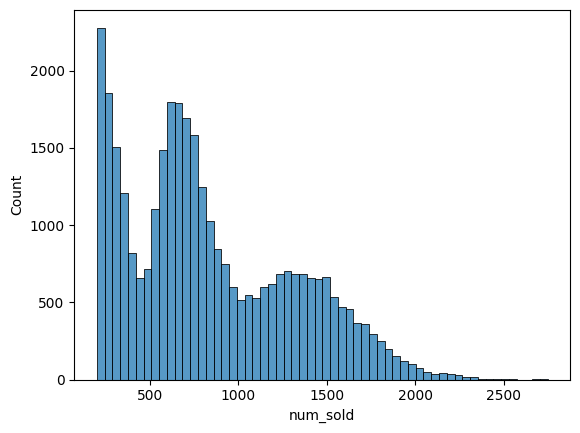

In [ ]:
#ver como se comportan los histogramas de num_sold por pais
sns.histplot(train_prepared[train_prepared['country_Canada'] == 1]['num_sold'])

<Axes: xlabel='num_sold', ylabel='Count'>

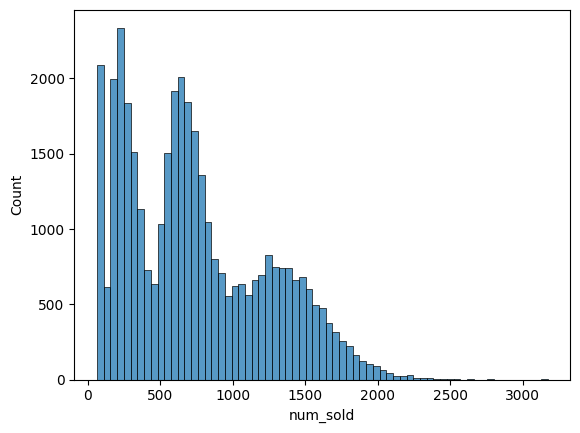

In [ ]:
sns.histplot(train_prepared[train_prepared['country_Finland'] == 1]['num_sold'])

<Axes: xlabel='num_sold', ylabel='Count'>

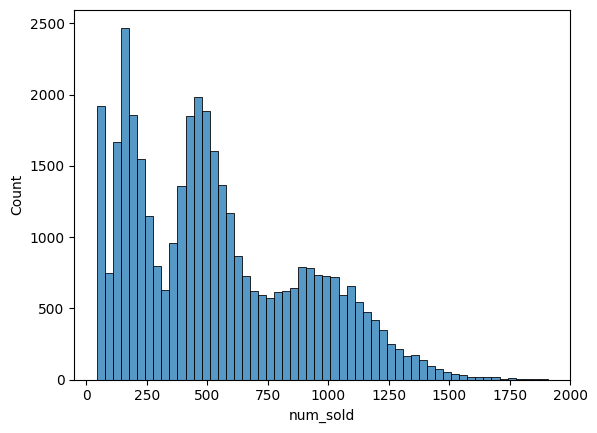

In [ ]:
sns.histplot(train_prepared[train_prepared['country_Italy'] == 1]['num_sold'])

<Axes: xlabel='num_sold', ylabel='Count'>

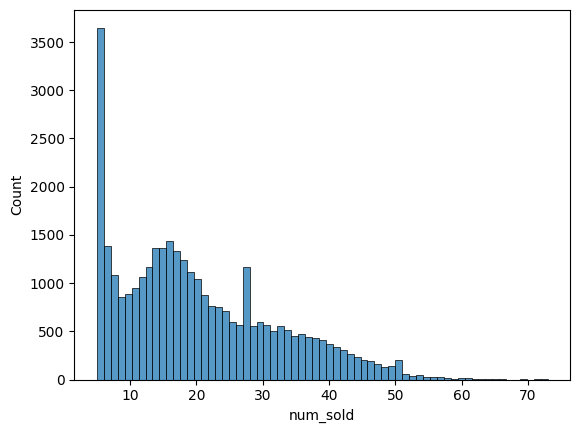

In [ ]:
sns.histplot(train_prepared[train_prepared['country_Kenya'] == 1]['num_sold'])

<Axes: xlabel='num_sold', ylabel='Count'>

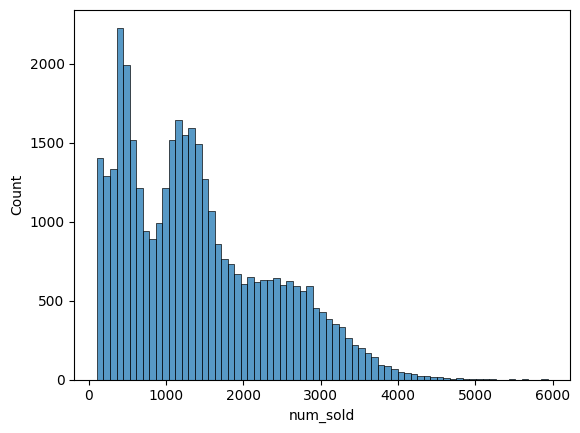

In [ ]:
sns.histplot(train_prepared[train_prepared['country_Norway'] == 1]['num_sold'])

<Axes: xlabel='num_sold', ylabel='Count'>

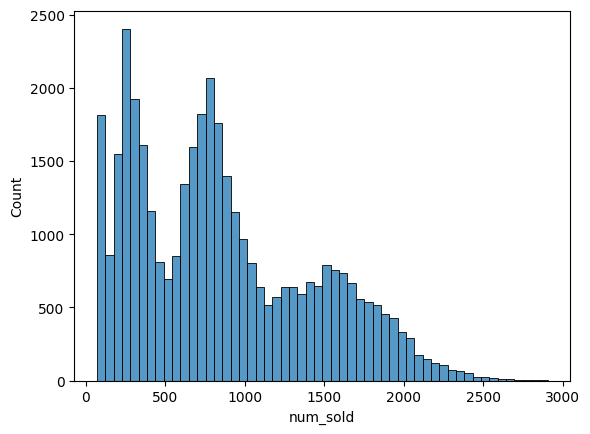

In [ ]:
sns.histplot(train_prepared[train_prepared['country_Singapore'] == 1]['num_sold'])

In [ ]:
#describir num_sold de train_prepared
train_prepared['num_sold'].describe()

,num_sold
count,221259.000000
mean,752.527382
std,690.165445
min,5.000000
25%,219.000000
50%,605.000000
75%,1114.000000
max,5939.000000


In [ ]:
#tratamiento de outliers todo valor arriba de 2500 se va de num_sold
#train_sin_outliers = train_prepared
train_sin_outliers = train_prepared[train_prepared['num_sold'] < 4000]

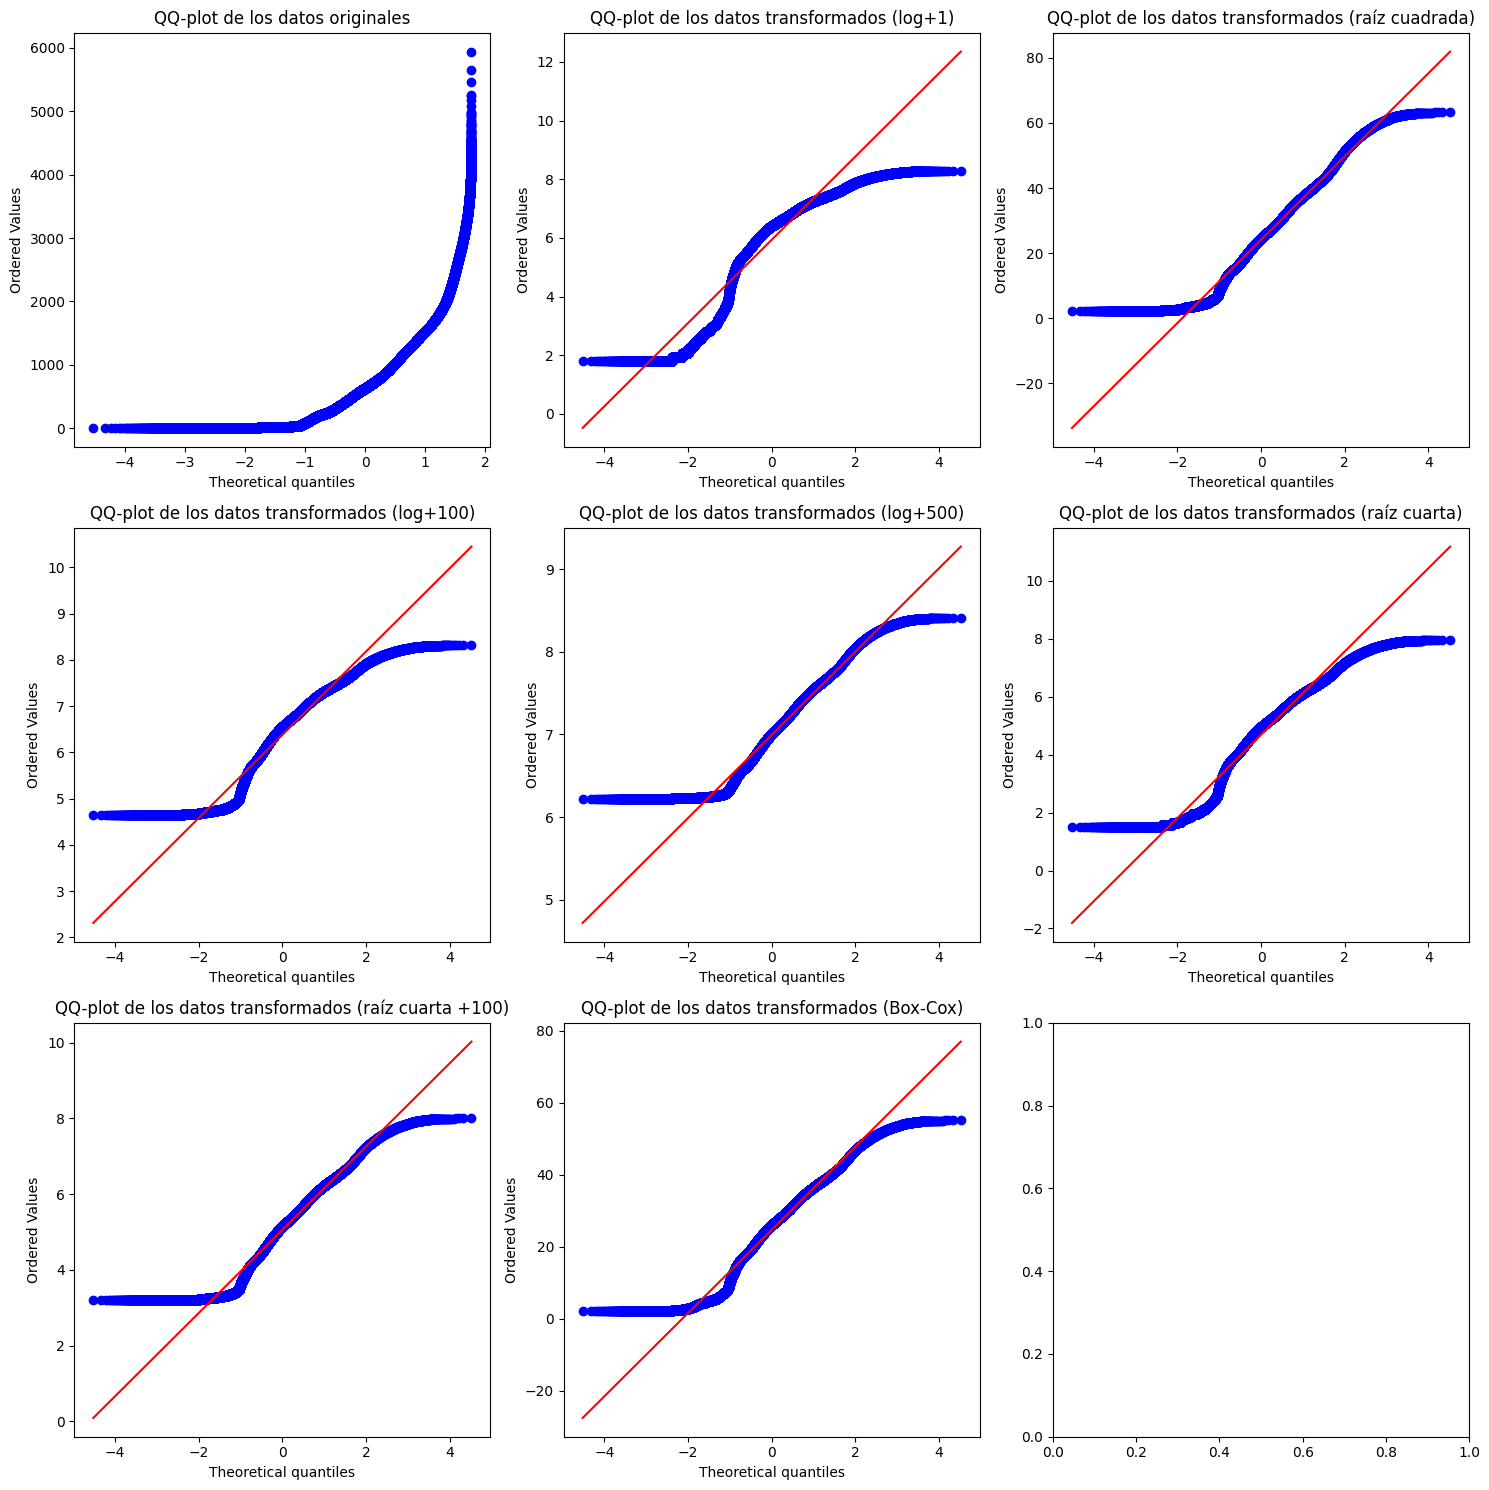

In [ ]:
#haremos un Q-Q plot de num_sold asi como probar con varias transformaciones para ver cual se asemeja mas a una normal
import matplotlib.pyplot as plt
import scipy.stats as stats
# Transformaciones (puedes agregar más)
log1_sales = np.log1p(train_sin_outliers['num_sold'])
sqrt_sales = np.sqrt(train_sin_outliers['num_sold'])
log100_sales = np.log(100+ train_sin_outliers['num_sold'])
log500_sales = np.log(500+ train_sin_outliers['num_sold'])
sqrt4_sales = (train_sin_outliers['num_sold'])**(1/4)
sqrt100_sales = (train_sin_outliers['num_sold']+100)**(1/4)
box_cox_sales, _ = stats.boxcox(train_sin_outliers['num_sold'])
# Crear subplots para comparar diferentes transformaciones
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# QQ-plot para los datos originales
# Access the correct subplot using axes[row, col]
stats.probplot(train_prepared['num_sold'], dist="norm", plot=axes[0, 0])
axes[0, 0].set_title("QQ-plot de los datos originales")

# QQ-plot para los datos transformados logarítmicamente +1
stats.probplot(log1_sales, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("QQ-plot de los datos transformados (log+1)")

# QQ-plot para los datos transformados con raíz cuadrada
stats.probplot(sqrt_sales, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title("QQ-plot de los datos transformados (raíz cuadrada)")

# QQ-plot para los datos transformados log +100
stats.probplot(log100_sales, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("QQ-plot de los datos transformados (log+100)")

#QQ-plot para los datos transformados log+500
stats.probplot(log500_sales, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("QQ-plot de los datos transformados (log+500)")

stats.probplot(sqrt4_sales, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title("QQ-plot de los datos transformados (raíz cuarta)")

stats.probplot(sqrt100_sales, dist="norm", plot=axes[2, 0])
axes[2, 0].set_title("QQ-plot de los datos transformados (raíz cuarta +100)")

stats.probplot(box_cox_sales, dist="norm", plot=axes[2, 1])
axes[2, 1].set_title("QQ-plot de los datos transformados (Box-Cox)")


plt.tight_layout()
plt.show()

#terminamos el encoding de las variables, ahora pasaremos al tratamiento de los de NaN como primera opcion sera eliminarlos, *queda pendiente tratar de rellenarlos de alguna forma como con otro modelo especifico de la tienda en la que se realizo el registro

In [ ]:
#hacer otro dataframe de data_prepared pero sin los NaN
train_prepared_no_nan = train_sin_outliers.dropna()
test_prepared_no_nan = test_prepared.dropna()

<Axes: xlabel='num_sold', ylabel='Count'>

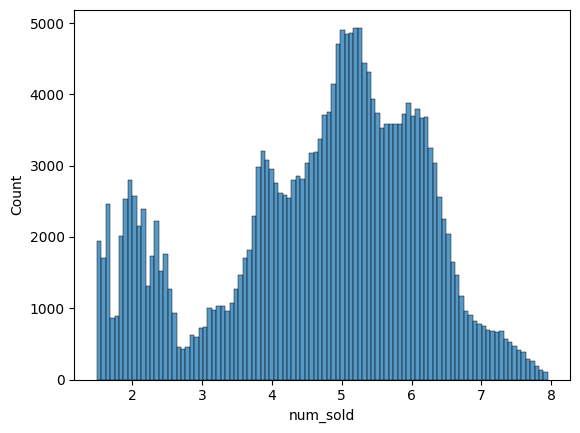

In [ ]:
#histograma de num_sold
sns.histplot(sqrt4_sales)

In [ ]:
#dividimos los datos de sqrt4_sales en sus dos distribuciones visibles
sqrt4_sales_0 = sqrt4_sales[sqrt4_sales < 2.82]
sqrt4_sales_1 = sqrt4_sales[sqrt4_sales >= 2.82]

In [ ]:
#agregar sqrt4_num sold a train_sin_outliers
train_sin_outliers['sqrt4_num_sold'] = sqrt4_sales

<ipython-input-124-c46d5780b764>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sin_outliers['sqrt4_num_sold'] = sqrt4_sales


In [ ]:
#dividir en 2 mis datos, poner un 0 en datos que sqrt4_num_sold sea menor que 2.82, y 1 para los demas
train_sin_outliers['sqrt4_num_sold_type'] = np.where(train_sin_outliers['sqrt4_num_sold'] < 2.82, 0, 1)

<ipython-input-125-15ea8e153f6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sin_outliers['sqrt4_num_sold_type'] = np.where(train_sin_outliers['sqrt4_num_sold'] < 2.82, 0, 1)


In [ ]:
#haremos un arbol de decision que identifique la columna bc_num_sold si es 0 o 1
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = train_sin_outliers.drop(['num_sold', 'sqrt4_num_sold','sqrt4_num_sold_type'], axis=1)
y = train_sin_outliers['sqrt4_num_sold_type']

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)
# Definir un rango de valores para max_depth
param_grid = {'max_depth': range(1, 15)}  # Probar profundidades de 1 a 10

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')

# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener la mejor profundidad
best_depth = grid_search.best_params_['max_depth']
print(f"La mejor profundidad es: {best_depth}")

La mejor profundidad es: 10


In [ ]:
arbol=DecisionTreeClassifier(max_depth=10)
arbol1=arbol.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
y_pred = arbol1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
#print recall del modelo
print(classification_report(y_test, y_pred))

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("\nROC AUC:", roc_auc)

Accuracy: 0.9987105531048523
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6901
           1       1.00      1.00      1.00     37304

    accuracy                           1.00     44205
   macro avg       1.00      1.00      1.00     44205
weighted avg       1.00      1.00      1.00     44205


Confusion Matrix:
[[ 6871    30]
 [   27 37277]]

ROC AUC: 0.9974645104845611


In [ ]:
#divideremos los datos en base a bc_num_sold
train_sin_outliers_0 = train_sin_outliers[train_sin_outliers['sqrt4_num_sold_type'] == 0]
train_sin_outliers_1 = train_sin_outliers[train_sin_outliers['sqrt4_num_sold_type'] == 1]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#entrenar un modelo ligthgbm con los datos de train_sin_outliers_0
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
X0 = train_sin_outliers_0.drop(['num_sold', 'sqrt4_num_sold','sqrt4_num_sold_type'], axis=1)
y0 = train_sin_outliers_0['sqrt4_num_sold']
X1 = train_sin_outliers_1.drop(['num_sold', 'sqrt4_num_sold','sqrt4_num_sold_type'], axis=1)
y1 = train_sin_outliers_1['sqrt4_num_sold']

In [ ]:
# Dividir datos
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=28)

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=28)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


Best parameters for 0: {'boosting_type': 'gbdt', 'learning_rate': 0.11300875650642028, 'num_leaves': 43, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.5840356498523489, 'colsample_bytree': 0.9518633280667154, 'reg_alpha': 0.0369278762314182, 'reg_lambda': 0.12445785031893541, 'n_estimators': 186}

Best parameters for 1: {'boosting_type': 'gbdt', 'learning_rate': 0.09381119378468639, 'num_leaves': 130, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.7752466759168669, 'colsample_bytree': 0.7970106859636505, 'reg_alpha': 0.10980863679607203, 'reg_lambda': 0.06644891346430068, 'n_estimators': 199}


ya tenemos los parametros

In [ ]:
#drop id de test_prepared
test_prepared.drop('id', axis=1, inplace=True)

In [ ]:
elegir_modelo = arbol1.predict(test_prepared)

In [ ]:
#agregamos elegir_modelo a test_prepared
test_prepared['type'] = elegir_modelo

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape

# Crea un objeto DMatrix para XGBoost
dtrain0 = xgb.DMatrix(X0_train, label=y0_train)
dtest0 = xgb.DMatrix(X0_test, label=y0_test)

# Define los parámetros del modelo
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'reg:squarederror',  # Para regresión
    'eval_metric': 'mape'
}

# Entrena el modelo
num_round = 100
modelxgb0 = xgb.train(params, dtrain0, num_round)

# Realiza predicciones
y0_pred = modelxgb0.predict(dtest0)

# Evalúa el modelo
map = mape(y0_test**4, y0_pred**4)
print("mape:", map)

mape: 0.056882966904569274


In [ ]:
# Crea un objeto DMatrix para XGBoost
dtrain1 = xgb.DMatrix(X1_train, label=y1_train)
dtest1 = xgb.DMatrix(X1_test, label=y1_test)

# Define los parámetros del modelo
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'reg:squarederror',  # Para regresión
    'eval_metric': 'mape'
}

# Entrena el modelo
num_round = 100
modelxgb1 = xgb.train(params, dtrain1, num_round)

# Realiza predicciones
y1_pred = modelxgb1.predict(dtest1)

# Evalúa el modelo
map = mape(y1_test**4, y1_pred**4)
print("mape:", map)

mape: 0.05021627005521316


In [ ]:
#ahora test_prepared se separa en base a type
test_prepared_0 = test_prepared[test_prepared['type'] == 0]
test_prepared_1 = test_prepared[test_prepared['type'] == 1]

In [ ]:
test_prepared_0.drop('type', axis=1, inplace=True)
test_prepared_1.drop('type', axis=1, inplace=True)

In [ ]:
modelxgb0_pred = modelxgb0.predict(xgb.DMatrix(test_prepared_0))
modelxgb1_pred = modelxgb1.predict(xgb.DMatrix(test_prepared_1))

In [ ]:
modelxgb0_pred_normal = modelxgb0_pred**4
modelxgb1_pred_normal = modelxgb1_pred**4

In [ ]:
#obtener index de los 1 de la columna type de test_prepared
index_1 = test_prepared[test_prepared['type'] == 1].index
index_0 = test_prepared[test_prepared['type'] == 0].index

In [ ]:
#juntar modelgbm0_pred_normal y modelgbm1_pred_normal en orden dependiendo index_1 y index_0
df_pred_normal = pd.DataFrame(index=test_prepared.index, columns=['num_sold']) # Create DataFrame with the correct index
df_pred_normal.loc[index_1, 'num_sold'] = modelxgb1_pred_normal
df_pred_normal.loc[index_0, 'num_sold'] = modelxgb0_pred_normal

In [ ]:
#extraer el id de test y concatenar las df_pred_normal
test_id = test['id']
test_preds5 = pd.DataFrame(df_pred_normal, columns=['num_sold'])
test_preds5 = pd.concat([test_id, df_pred_normal], axis=1)
test_preds5.to_csv('test_preds5.csv', index=False)

<Axes: xlabel='num_sold', ylabel='Count'>

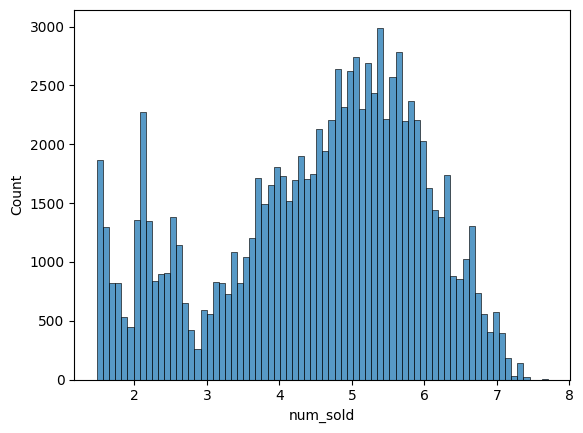

In [ ]:
sns.histplot(test_preds5['num_sold']**(1/4))

#ligth gbm

In [ ]:
#fiteamos los modelo para type 0 y 1
modelgbm0 = lgb.LGBMRegressor(boosting_type = 'gbdt', learning_rate = 0.11300875650642028, num_leaves= 43,
                              max_depth= 9, min_child_samples= 21, subsample= 0.5840356498523489,
                              colsample_bytree= 0.9518633280667154, reg_alpha= 0.0369278762314182,
                              reg_lambda= 0.12445785031893541, n_estimators= 186)
modelgbm1 = lgb.LGBMRegressor(boosting_type= 'gbdt', learning_rate= 0.09381119378468639, num_leaves= 130, max_depth= 9,
                              min_child_samples= 9, subsample= 0.7752466759168669, colsample_bytree= 0.7970106859636505,
                              reg_alpha= 0.10980863679607203, reg_lambda= 0.06644891346430068, n_estimators= 199)

modelgbm0.fit(X0_train, y0_train)
modelgbm1.fit(X1_train, y1_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 27538, number of used features: 16
[LightGBM] [Info] Start training from score 2.070692
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73
[LightGBM] [Info] Number of data points in the train set: 149281, number of used features: 24
[LightGBM] [Info] Start training from score 5.168359
[LightGBM] [Warning] No further

LGBMRegressor(colsample_bytree=0.7970106859636505,
              learning_rate=0.09381119378468639, max_depth=9,
              min_child_samples=9, n_estimators=199, num_leaves=130,
              reg_alpha=0.10980863679607203, reg_lambda=0.06644891346430068,
              subsample=0.7752466759168669)

In [ ]:
#ahora test_prepared se separa en base a type
test_prepared_0 = test_prepared[test_prepared['type'] == 0]
test_prepared_1 = test_prepared[test_prepared['type'] == 1]

In [ ]:
test_prepared_0.drop('type', axis=1, inplace=True)
test_prepared_1.drop('type', axis=1, inplace=True)

In [ ]:
modelgbm0_pred = modelgbm0.predict(test_prepared_0)
modelgbm1_pred = modelgbm1.predict(test_prepared_1)

In [ ]:
modelgbm0_pred_normal = modelgbm0_pred**4
modelgbm1_pred_normal = modelgbm1_pred**4

In [ ]:
#obtener index de los 1 de la columna type de test_prepared
index_1 = test_prepared[test_prepared['type'] == 1].index
index_0 = test_prepared[test_prepared['type'] == 0].index

In [ ]:
#juntar modelgbm0_pred_normal y modelgbm1_pred_normal en orden dependiendo index_1 y index_0
df_pred_normal = pd.DataFrame(index=test_prepared.index, columns=['num_sold']) # Create DataFrame with the correct index
df_pred_normal.loc[index_1, 'num_sold'] = modelgbm1_pred_normal
df_pred_normal.loc[index_0, 'num_sold'] = modelgbm0_pred_normal

In [ ]:
#extraer el id de test y concatenar las df_pred_normal
test_id = test['id']
test_preds4 = pd.DataFrame(df_pred_normal, columns=['num_sold'])
test_preds4 = pd.concat([test_id, df_pred_normal], axis=1)

In [ ]:
#guardad como csv test_preds1
test_preds4.to_csv('test_preds4.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split
train_prepared_no_nan['num_sold'] = np.log1p(train_prepared_no_nan['num_sold'])
X = train_prepared_no_nan.drop(['num_sold'], axis=1)
y = train_prepared_no_nan['num_sold']
#test = test_data.drop(['id'],axis=1)

# Split datainto training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-24-e63a70755cbf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prepared_no_nan['num_sold'] = np.log1p(train_prepared_no_nan['num_sold'])


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb

In [ ]:
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(np.expm1(y_true), np.expm1(y_pred))

In [ ]:
SEED = 42
n_estimators = 10000
early_stopping_rounds = 50
n_splits = 5


In [ ]:
kf = KFold(n_splits, shuffle=True, random_state=SEED)
kf_splits = kf.split(X)
scores1 = []
test_preds1 = []

lgbm_params1 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': n_estimators,
    'learning_rate': 0.08,
    'max_depth': 13,
    'reg_alpha': 0.01,
    'lambda_l2': 0.01,
    'min_child_samples' : 32,
    'colsample_bytree': 0.93,
    'subsample': 0.7,
    'seed': SEED,
    'verbose': -1,
    'device' : 'cpu'
}

for i, (train_idx, val_idx) in enumerate(kf_splits):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    #train_lgbm_dataset = lgb.Dataset(X_train_fold, label=y_train_fold, categorical_feature=cat_cols)
    #valid_lgbm_dataset = lgb.Dataset(X_val_fold, label=y_val_fold, categorical_feature=cat_cols)

    callbacks = [lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False)]
    model = lgb.LGBMRegressor(**lgbm_params1)
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)],eval_metric='rmse', callbacks=callbacks)

    val_pred = model.predict(X_val_fold, num_iteration=model.best_iteration_)
    score = mape(y_val_fold, val_pred)
    scores1.append(score)

    print(f'LightGBM Fold {i + 1} mape: {score}')
print(f'LightGBM mape: {np.mean(scores1):.5f};');

LightGBM Fold 1 mape: 0.051388726655734296
LightGBM Fold 2 mape: 0.05089326343949638
LightGBM Fold 3 mape: 0.050695253256291505
LightGBM Fold 4 mape: 0.0508146017932491
LightGBM Fold 5 mape: 0.05096842289939279
LightGBM mape: 0.05095;


In [ ]:
#sacamos las predicciones de test
test_preds1 = model.predict(test_prepared_no_nan)
test_preds1 = np.expm1(test_preds1)

In [ ]:
test.shape

(98550, 9)

In [ ]:
test_preds1.shape

(98550,)

In [ ]:
#extraer el id de test y concatenar las test_preds1
test_id = test['id']
test_preds1 = pd.DataFrame(test_preds1, columns=['num_sold'])
test_preds1 = pd.concat([test_id, test_preds1], axis=1)

In [ ]:
test_preds1.head()

,id,num_sold
0,230130,119.093547
1,230131,743.370232
2,230132,678.196328
3,230133,326.396190
4,230134,423.048797


In [ ]:
#guardad como csv test_preds1
test_preds1.to_csv('test_preds1.csv', index=False)